In [34]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from tqdm import tqdm
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

from copy import deepcopy

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, f1_score, roc_auc_score

In [2]:
ds_path = Path('./data')
seed = 21

### Загрузим датасеты и рассмотрим их

In [3]:
df_train = pd.read_csv(ds_path/'car_train.csv')
df_out_test = pd.read_csv(ds_path/'car_test.csv')

df_driver_info = pd.read_csv(ds_path/'driver_info.csv')                     # done
df_fix_info = pd.read_csv(ds_path/'fix_info.csv', parse_dates=['fix_date']) # done
df_rides_info = pd.read_csv(ds_path/'rides_info.csv')

#### df_driver_info

In [4]:
df_driver_info.head(3)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15


In [5]:
# Что-то не так с датами у этой части датасета, посмотрим какие записи повреждены

df_driver_info[['s_ye', 's_mo', 's_da']] = df_driver_info.first_ride_date.str.split('-', expand=True).astype(int)
df_driver_info_patched = df_driver_info.drop(columns=['first_ride_date']).copy(True)

def is_correct_date(x):
    try:
        datetime.datetime.strptime(f'{x.s_ye}-{x.s_mo}-{x.s_da}', '%Y-%m-%d')
        return True
    except:
        return False

df_driver_info_patched['is_correct_date'] = df_driver_info_patched.apply(lambda x: is_correct_date(x), axis=1)

In [6]:
# Ага, а вот и виновник торжества!
# В феврале всего 28 дней. Поменяем 29 и 30 дни на последний корректный в месяце
#df_incorrect = df_driver_info_patched.query('is_correct_date == False')
#df_driver_info_patched.at[df_driver_info_patched.s_da > 28, 's_da']

fi = ((df_driver_info_patched.s_da > 28) & (df_driver_info_patched.s_mo == 2))
df_driver_info_patched.loc[fi, 's_da'] = 28


df_driver_info_patched['first_ride_date'] = pd.to_datetime(dict(
    year=df_driver_info_patched.s_ye,
    month=df_driver_info_patched.s_mo,
    day=df_driver_info_patched.s_da
))

df_driver_info = df_driver_info_patched.drop(columns=['is_correct_date', 's_da', 's_mo', 's_ye']).copy()
df_driver_info['has_accidents'] = df_driver_info.user_time_accident.map(lambda x: True if x > 0 else False)
df_driver_info.head(3)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date,has_accidents
0,27,9.0,865,19.0,l17437965W,1,2019-04-02,True
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19,True
2,59,7.8,947,4.0,g11098715c,0,2021-01-15,True


In [7]:
df_driver_info['round_rating'] = df_driver_info.user_rating.round()

age	user_rating	user_rides	user_time_accident	user_id	sex	first_ride_date

**Идеи для driver_info**
1. first_ride_date: 2017-2019 + 2020-2021 - в основном женщины 2019-2020 + >21 - мужчины +
2. Зависимости между first_ride_date и user_rating нет, ровно как и зависимости user_rating от пола +
3. Водители до 34 лет - в основном женщины. При этом у водителей старше 50 лет в среднем меньше поездок +
4. Количество аварий у мужчин и женщин схоже + 
5. Чем старше человек, тем меньше у него аварий в среднем +
6. Парадоксальный парадокс! У девушек, которые попадали в аварию,  рейтинг в такси лучше, чем у мужчин, которые в аварию не попадали +

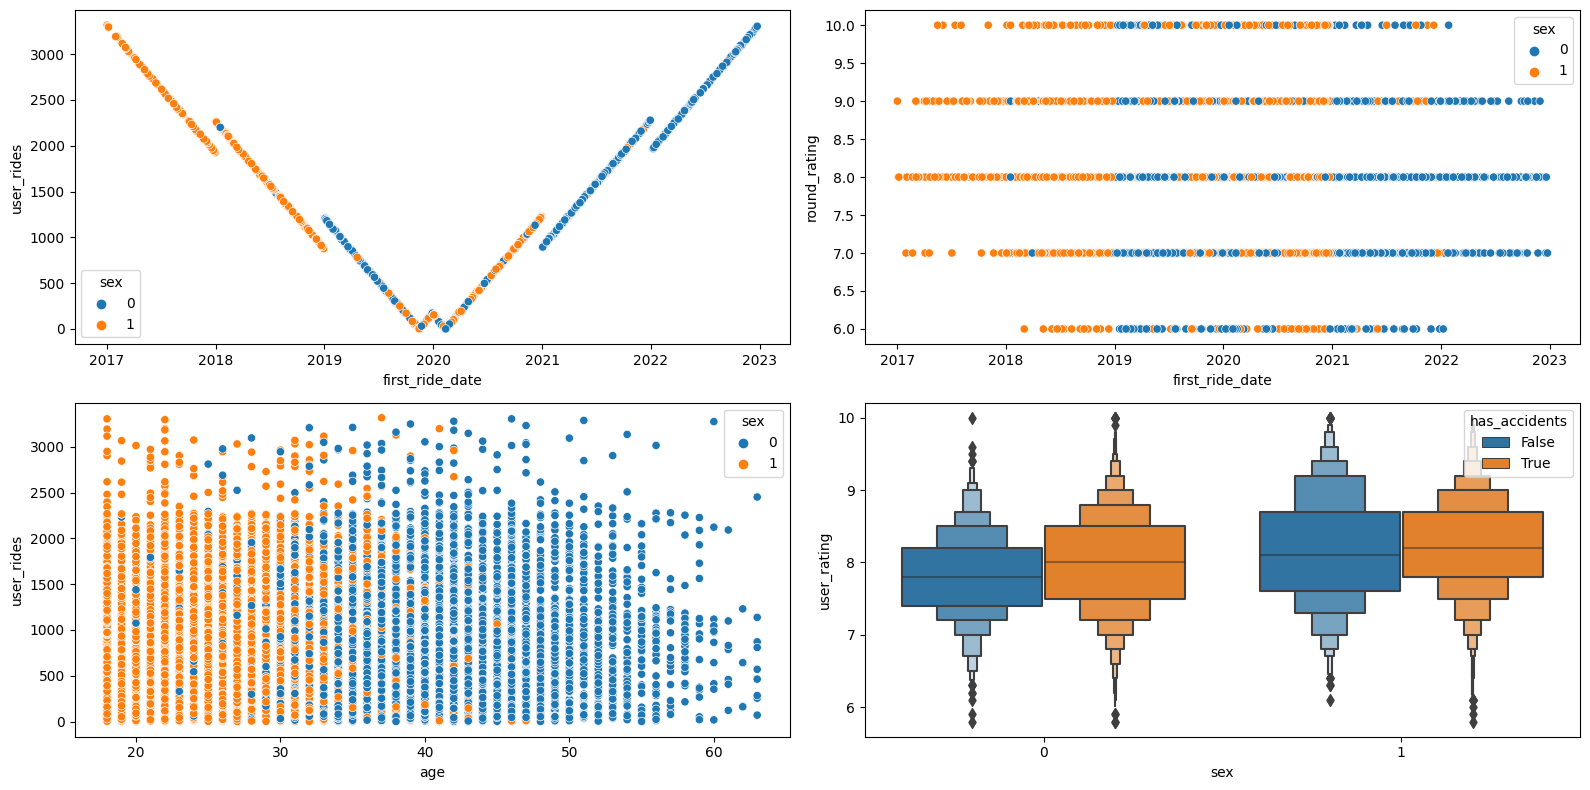

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

sns.scatterplot(
    data=df_driver_info,
    x='first_ride_date',
    y='user_rides',
    hue='sex',
    ax=axs[0][0]
)

sns.scatterplot(
    data=df_driver_info,
    x='first_ride_date',
    y='round_rating',
    hue='sex',
    ax=axs[0][1]
)

sns.scatterplot(
    data=df_driver_info,
    x='age',
    y='user_rides',
    hue='sex',
    ax=axs[1][0]
)

sns.boxenplot(
    data=df_driver_info,
    x='sex',
    y='user_rating',
    hue='has_accidents',
    ax=axs[1][1]
)

plt.tight_layout()
plt.show()

In [9]:
# А теперь сделаем новые фичи на основе идей
df_driver_info['grow_tendency'] = df_driver_info.first_ride_date.dt.year.map(lambda x: 1 if x > 2020 else 0)
df_driver_info['younger_woman_32'] = df_driver_info.age.map(lambda x: 1 if x <= 32 else 0)
df_driver_info.drop(columns='round_rating', inplace=True)
df_driver_info.head(3)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date,has_accidents,grow_tendency,younger_woman_32
0,27,9.0,865,19.0,l17437965W,1,2019-04-02,True,0,1
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19,True,1,0
2,59,7.8,947,4.0,g11098715c,0,2021-01-15,True,1,0


d#### df_fix_info
Идеи:
1. чем больше d_total, тем меньше target_reg (cor 0.434499!)
2. target_classify очень сильно зависит от target_regression


In [10]:
df_fix_info_c = df_fix_info.copy(True)
df_fix_info_c['fixed_fix_date'] = pd.to_datetime(df_fix_info_c.fix_date, errors='coerce')

flt = df_fix_info_c.fixed_fix_date.isna()
tmp = df_fix_info_c[flt].fix_date
tmp = tmp.str.replace('30', '28').str.replace('29', '28')

df_fix_info_c.loc[flt, 'fixed_fix_date'] = tmp
df_fix_info_c['fix_date'] = pd.to_datetime(df_fix_info_c.fixed_fix_date)
df_fix_info_c.drop(columns='fixed_fix_date', inplace=True)

df_fix_info_c.head(3)
df_fix_info = df_fix_info_c

In [11]:
# Очевидный признак: во сколько был начат ремонт? Если ремонт стали проводить ночью, то 
df_fix_info_t = df_fix_info.copy(True)

def start_of_repair(s):
    return (s.fix_date.hour - s.work_duration) % 24

df_fix_info_t['repair_start_hour'] = df_fix_info_c.apply(start_of_repair, axis=1)
# он оказался бесполезным...

# вторая идея: объединение destroy_degree и work_duration
df_fix_info_t['work_amount'] = df_fix_info.destroy_degree * df_fix_info.work_duration
df_fix_info_t['work_scope'] = df_fix_info.destroy_degree / df_fix_info.work_duration

df_fix_info_t.head(3)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration,repair_start_hour,work_amount,work_scope
0,P17494612l,RJ,2020-06-20 02:14:00,reparking,8.0,49,1,392.0,0.163265
1,N-1530212S,LM,2020-02-09 20:25:00,repair,10.0,48,20,480.0,0.208333
2,B-1154399t,ND,2019-08-24 07:01:00,reparking,1.0,27,4,27.0,0.037037


In [12]:
df_fix_info_t['day_rounded'] = df_fix_info_t.fix_date.round('D')
tmp = df_fix_info_t['work_amount'].groupby(by=[df_fix_info_t.day_rounded.dt.year, df_fix_info_t.day_rounded.dt.month])
tmp = tmp.sum('work_amount')
tmp.head(3)

day_rounded  day_rounded
2017         1              3542.4
             2              1217.0
             3              1611.9
Name: work_amount, dtype: float64

In [13]:
idx = pd.to_datetime(tmp.index.map(lambda x: f'{x[0]}-{x[1]}-1'))
tmp.index = idx

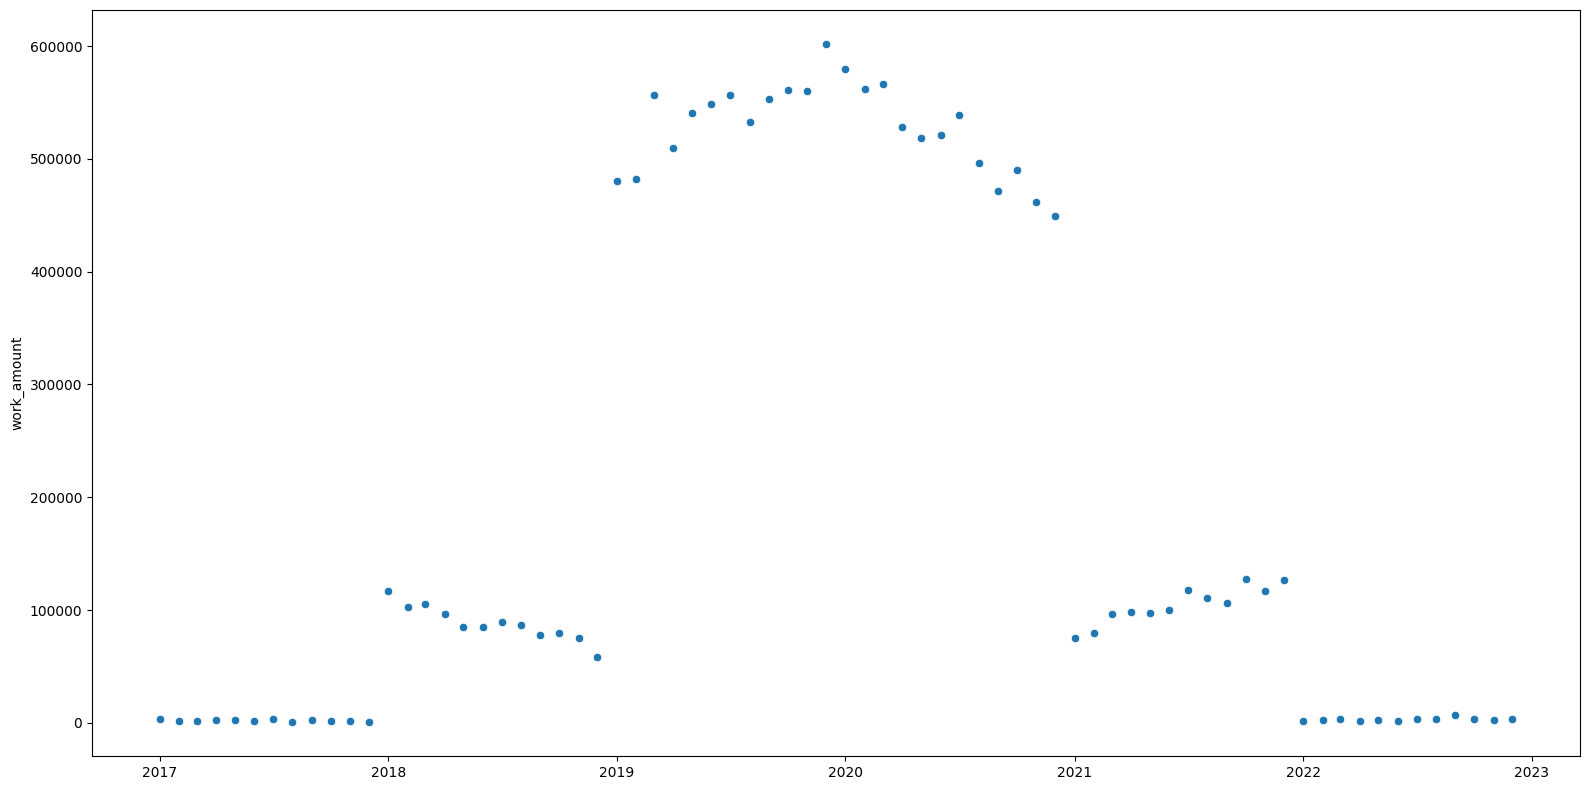

In [14]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(
    data=tmp,
    ax=ax,
)

plt.tight_layout()
plt.show()

In [15]:
df_destroy_degrees = df_fix_info_t[['destroy_degree', 'car_id']].groupby('car_id').agg(d_cnt=('destroy_degree', 'count'), d_total=('destroy_degree', 'sum'))
df_destroy_degrees.head(3)

,d_cnt,d_total
car_id,,
A-1049127W,35,95.0
A-1079539w,34,147.2
A-1162143G,34,126.0


In [16]:
df_train_tmp = df_train.merge(df_destroy_degrees, on='car_id')
df_test_tmp  = df_out_test.merge(df_destroy_degrees, on='car_id')

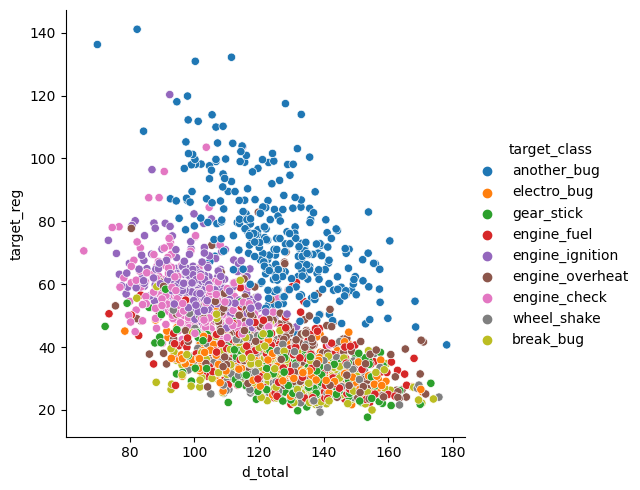

In [17]:
sns.relplot(
    data=df_train_tmp,
    x='d_total',
    y='target_reg',
    hue='target_class'
)

In [18]:
df_train_tmp.corr()

/var/folders/v0/3bxqm55x4zs_clnj1gmt_1780000gp/T/ipykernel_14021/1227243942.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train_tmp.corr()


,car_rating,year_to_start,riders,year_to_work,target_reg,d_cnt,d_total
car_rating,1.000000,-0.016672,-0.013615,-0.017544,0.022625,-0.034940,-0.005635
year_to_start,-0.016672,1.000000,0.986746,0.059072,0.006814,-0.019523,-0.025415
riders,-0.013615,0.986746,1.000000,0.048270,0.003588,-0.027581,-0.023428
year_to_work,-0.017544,0.059072,0.048270,1.000000,0.033645,-0.024433,-0.014766
target_reg,0.022625,0.006814,0.003588,0.033645,1.000000,0.007719,-0.434499
d_cnt,-0.034940,-0.019523,-0.027581,-0.024433,0.007719,1.000000,0.047347
d_total,-0.005635,-0.025415,-0.023428,-0.014766,-0.434499,0.047347,1.000000


In [19]:
tmp = df_train_tmp[['target_class', 'target_reg', 'd_total']]
tmp = pd.get_dummies(tmp, columns=['target_class'])
tmp.corr()


,target_reg,d_total,target_class_another_bug,target_class_break_bug,target_class_electro_bug,target_class_engine_check,target_class_engine_fuel,target_class_engine_ignition,target_class_engine_overheat,target_class_gear_stick,target_class_wheel_shake
target_reg,1.000000,-0.434499,0.643870,-0.246578,-0.224923,0.194828,-0.173054,0.289651,-0.107241,-0.242991,-0.179477
d_total,-0.434499,1.000000,0.094060,0.119004,0.096991,-0.381824,0.101828,-0.339762,0.113184,0.133960,0.073664
target_class_another_bug,0.643870,0.094060,1.000000,-0.133073,-0.127149,-0.133073,-0.130834,-0.132795,-0.138313,-0.136944,-0.101483
target_class_break_bug,-0.246578,0.119004,-0.133073,1.000000,-0.124809,-0.130624,-0.128426,-0.130350,-0.135767,-0.134424,-0.099615
target_class_electro_bug,-0.224923,0.096991,-0.127149,-0.124809,1.000000,-0.124809,-0.122709,-0.124548,-0.129723,-0.128440,-0.095180
target_class_engine_check,0.194828,-0.381824,-0.133073,-0.130624,-0.124809,1.000000,-0.128426,-0.130350,-0.135767,-0.134424,-0.099615
target_class_engine_fuel,-0.173054,0.101828,-0.130834,-0.128426,-0.122709,-0.128426,1.000000,-0.128157,-0.133483,-0.132162,-0.097939
target_class_engine_ignition,0.289651,-0.339762,-0.132795,-0.130350,-0.124548,-0.130350,-0.128157,1.000000,-0.135483,-0.134142,-0.099406
target_class_engine_overheat,-0.107241,0.113184,-0.138313,-0.135767,-0.129723,-0.135767,-0.133483,-0.135483,1.000000,-0.139717,-0.103537
target_class_gear_stick,-0.242991,0.133960,-0.136944,-0.134424,-0.128440,-0.134424,-0.132162,-0.134142,-0.139717,1.000000,-0.102512


### Подготовим данные для обучения baseline-модели

In [20]:
# Добавим признаки из других датасетов
def enhance_features(ds):
    tmp_main = ds.copy(True)

    tmp = tmp_main
    tmp = df_rides_info.merge(df_driver_info, on='user_id').groupby('car_id').agg(
        mean_age=('age', 'mean'),
        mean_rating=('user_rating', 'mean'),
        total_rides=('user_rides', 'sum'),
        total_acc_count=('user_time_accident', 'sum'),
        avg_sex=('sex', 'mean'),
        mean_tendency=('grow_tendency', 'mean'),
        mean_wo=('younger_woman_32', 'mean'),

        mean_ride_rating=('rating', 'mean'),
        mean_ride_duration=('ride_duration', 'mean'),
        mean_ride_cost=('ride_cost', 'mean'),
        ma_speed=('speed_avg', 'mean'),
        ma_max_speed=('speed_max', 'mean'),
        total_stop_counts=('stop_times', 'sum'),
        total_distance=('distance', 'sum'),
        total_refueling=('refueling', 'sum'),

        mean_user_ride_quality=('user_ride_quality', 'mean'),
        total_deviations=('deviation_normal', 'sum')

    )

    tmp = tmp.merge(df_destroy_degrees, on='car_id')
    tmp = tmp_main.merge(tmp, on='car_id')
    return tmp


data = enhance_features(df_train)
data_test = enhance_features(df_out_test)

In [21]:
# Посмотрим, какие колонки есть
cat_cols = [
    'model',
    'car_type',
    'fuel_type'
]

num_cols = [
    'car_rating',
    'year_to_start',
    'riders',
    'year_to_work',
    'mean_age',
    'mean_rating',
    'total_rides',
    'total_acc_count',
    'avg_sex',
    'mean_tendency',
    'mean_wo',
    'mean_ride_rating',
    'mean_ride_duration',
    'mean_ride_cost',
    'ma_speed',
    'ma_max_speed',
    'total_stop_counts',
    'total_distance',
    'total_refueling',
    'mean_user_ride_quality',
    'total_deviations',
    'd_cnt',
    'd_total'
]

tgt_reg = 'target_reg'
tgt_class = 'target_class'

tgt_cols = [
    tgt_reg,
    tgt_class,
]

fit_cols = [
    *cat_cols, *num_cols
]

In [22]:
# Подготовим baseline пайплайн по обработке данных
categorical_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='error')),
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

trf_columns = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, cat_cols),
    ('num', numerical_pipeline, num_cols),
])

trf_pipeline = Pipeline([
    ('initial', trf_columns),
    ('scaler', StandardScaler())
])

In [23]:
k = 5

reg_models = [
    ('XGBRegressor', XGBRegressor()),
    ('CatBoostRegressor', CatBoostRegressor(silent=True)),
]

reg_metrics = [
    ('r2', r2_score),
    ('mse', mean_squared_error),
    ('rmse', lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5)
]

folder = KFold(n_splits=k)

In [24]:
def logits_f(fits, X):
    y_test_pred = fits[0].predict(X)
    for f in fits[1:]:
        y_test_pred += f.predict(X)
    return y_test_pred

def predict_fr(fits, X):
    return logits_f(fits, X) / len(fits)

def predict_fc(fits, X):
    y_test_pred = fits[0].predict_proba(X)
    for f in fits[1:]:
        y_test_pred += f.predict_proba(X)
    return np.argmax(y_test_pred, axis=-1)

def fit_score(model, trf_pipeline, folder, X_train, y_train, X_test, y_test, metrics, is_reg=True, hook):
    fits = []
    predictor = predict_fr if is_reg else predict_fc
    

    def calc_metrics(y_true, y_pred, title='Metrics'):
        print(f'\t{title}', end=' ')
        scores = {}


        for metric_name, metric in metrics:
            m_result = metric(y_true, y_pred)
            scores[metric_name] = m_result

            print(f'{metric_name}={m_result:.2f}', end=' ')
        print()
        return scores
    

    pipeline = Pipeline([
        ('data', trf_pipeline),
        ('model', model)
    ])

    folds = enumerate(folder.split(X_train, y_train))
    for i, (train_idx, test_idx) in folds:
        print(f'Fitting fold[{i}]')
        
        X_cv_train, y_cv_train = X_train.loc[train_idx], y_train.loc[train_idx]
        X_cv_test, y_cv_test   = X_train.loc[test_idx], y_train.loc[test_idx]

        pipeline.fit(X_cv_train, y_cv_train)

        y_cv_train_pred = pipeline.predict(X_cv_train)
        y_cv_test_pred = pipeline.predict(X_cv_test)

        calc_metrics(y_cv_train, y_cv_train_pred, title='cv pred:')
        calc_metrics(y_cv_test, y_cv_test_pred, title='cv test:')

        fits.append(deepcopy(pipeline))
    
    # Проверим на тестовых данных
    y_test_pred = predictor(fits, X_test)
    scores = calc_metrics(y_test, y_test_pred, title='**TEST**')
    
    return fits, scores


In [25]:
# Для выбора лучшей модели
X_train, X_test, Y_train, Y_test = train_test_split(
    data[fit_cols], data[tgt_cols], test_size=0.08, random_state=seed
)

# Починим индексы для kfold/а
X_train.reset_index(inplace=True)
Y_train.reset_index(inplace=True)

**Идея 1:**
Каждую поломку можно оценить и на основе этого построить кастомную метрику для классификации. Возможно тогда будет нормальная корреляция с бордой на кагле

- target_reg - сколько дней до поломки?
- target_class - какой тип поломки будет?

In [26]:
# Ну и обучим модели

results = {
    'scores': {},
    'model': {},
}

for model_name, model in reg_models:
    fits, scores = fit_score(model, trf_pipeline, folder, X_train, Y_train[tgt_reg], X_test, Y_test[tgt_reg], reg_metrics)
    
    results['model'][model_name] = fits
    results['scores'][model_name] = scores

Fitting fold[0]
	cv pred: r2=1.00 mse=0.57 rmse=0.76 
	cv test: r2=0.76 mse=79.92 rmse=8.94 
Fitting fold[1]
	cv pred: r2=1.00 mse=0.90 rmse=0.95 
	cv test: r2=0.79 mse=65.53 rmse=8.10 
Fitting fold[2]
	cv pred: r2=1.00 mse=0.63 rmse=0.79 
	cv test: r2=0.78 mse=81.21 rmse=9.01 
Fitting fold[3]
	cv pred: r2=1.00 mse=0.45 rmse=0.67 
	cv test: r2=0.71 mse=69.72 rmse=8.35 
Fitting fold[4]
	cv pred: r2=1.00 mse=0.47 rmse=0.68 
	cv test: r2=0.73 mse=80.35 rmse=8.96 
	**TEST** r2=0.75 mse=84.88 rmse=9.21 
Fitting fold[0]
	cv pred: r2=0.97 mse=7.85 rmse=2.80 
	cv test: r2=0.78 mse=71.43 rmse=8.45 
Fitting fold[1]
	cv pred: r2=0.97 mse=7.91 rmse=2.81 
	cv test: r2=0.80 mse=60.35 rmse=7.77 
Fitting fold[2]
	cv pred: r2=0.97 mse=7.68 rmse=2.77 
	cv test: r2=0.80 mse=73.56 rmse=8.58 
Fitting fold[3]
	cv pred: r2=0.98 mse=7.94 rmse=2.82 
	cv test: r2=0.76 mse=57.29 rmse=7.57 
Fitting fold[4]
	cv pred: r2=0.98 mse=7.25 rmse=2.69 
	cv test: r2=0.75 mse=73.88 rmse=8.60 
	**TEST** r2=0.77 mse=77.14 rms

In [27]:
pd.DataFrame(results['scores'].values(), index=results['scores'].keys())

,r2,mse,rmse
XGBRegressor,0.751651,84.876039,9.212819
CatBoostRegressor,0.774280,77.142625,8.783087


In [28]:
results['model']['CatBoostRegressor'][0]

Pipeline(steps=[('data',
                 Pipeline(steps=[('initial',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('ohe',
                                                                                    OneHotEncoder())]),
                                                                   ['model',
                                                                    'car_type',
                                                                    'fuel_type']),
                                                                  ('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer())]),
                                                                   ['car_rating',
                                                                    'year_to_start',
                                                                    'riders',
                                                                    'year_to_work',
                                                                    'mean_age',
                                                                    'mean_rating',
                                                                    'total_rides',
                                                                    'total_acc_count',
                                                                    'avg_sex',
                                                                    'mean_tendency',
                                                                    'mean_wo',
                                                                    'mean_ride_rating',
                                                                    'mean_ride_duration',
                                                                    'mean_ride_cost',
                                                                    'ma_speed',
                                                                    'ma_max_speed',
                                                                    'total_stop_counts',
                                                                    'total_distance',
                                                                    'total_refueling',
                                                                    'mean_user_ride_quality',
                                                                    'total_deviations',
                                                                    'd_cnt',
                                                                    'd_total'])])),
                                 ('scaler', StandardScaler())])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7ff369312fd0>)])

На бейзлайн-pipeline/е CatBoostRegressor работает получше. Сгенерируем с его помощью target_reg для классификации

In [29]:
data_train = data.copy(True)
data_train['target_reg'] = predict_fr(results['model']['CatBoostRegressor'], data_train.drop(columns='target_reg'))

enc = LabelEncoder()
data_train['target_class'] = enc.fit_transform(data_train['target_class'])

data_test['target_reg'] = predict_fr(results['model']['CatBoostRegressor'], data_test)
data_test.target_reg.describe()

count    1913.000000
mean       44.628393
std        14.848412
min        23.934211
25%        32.903269
50%        39.510359
75%        53.913475
max       103.855066
Name: target_reg, dtype: float64

Подготовим все для классификации

In [49]:
clf_models = [
    ('XGBClassifier', XGBClassifier()),
    ('CatBoostClassifier', CatBoostClassifier(silent=True)),
]

clf_metrics = [
    ('accuracy', accuracy_score),
    ('precision', lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted')),
    ('f1', lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')),
]

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data_train[fit_cols], data_train[tgt_cols], test_size=0.08, random_state=seed
)

# Починим индексы для kfold/а
X_train.reset_index(inplace=True)
Y_train.reset_index(inplace=True)

In [51]:
for model_name, model in clf_models:
    fits, scores = fit_score(model, trf_pipeline, folder, X_train, Y_train[tgt_class], X_test, Y_test[tgt_class], clf_metrics, is_reg=False)
    
    results['model'][model_name] = fits
    results['scores'][model_name] = scores

Fitting fold[0]
	cv pred: accuracy=1.00 precision=1.00 f1=1.00 
	cv test: accuracy=0.98 precision=0.98 f1=0.98 
Fitting fold[1]
	cv pred: accuracy=1.00 precision=1.00 f1=1.00 
	cv test: accuracy=0.97 precision=0.97 f1=0.97 
Fitting fold[2]
	cv pred: accuracy=1.00 precision=1.00 f1=1.00 
	cv test: accuracy=0.97 precision=0.97 f1=0.97 
Fitting fold[3]
	cv pred: accuracy=1.00 precision=1.00 f1=1.00 
	cv test: accuracy=0.98 precision=0.98 f1=0.98 
Fitting fold[4]
	cv pred: accuracy=1.00 precision=1.00 f1=1.00 
	cv test: accuracy=0.96 precision=0.96 f1=0.96 
	**TEST** accuracy=0.98 precision=0.98 f1=0.98 
Fitting fold[0]


KeyboardInterrupt: 

In [33]:
data_test['target_class'] = predict_fc(results['model']['CatBoostClassifier'], data_test)
data_test['target_class'] = enc.inverse_transform(data_test.target_class)

data_test[['car_id', 'target_class']].to_csv('my_baseline_v1.csv', index=False)

roc-auc=0.972